# 음성인식 실습

220922, by *wygo*

- OpenAI의 , 27sec 음성을 12sec 이내에 음성인식 완료. 성능도 괜찮음

- [실습코드](https://github.com/airobotlab/asr_whisper_korea_colab)
- [blog](https://openai.com/blog/whisper/)
- [paper](https://cdn.openai.com/papers/whisper.pdf)
- [code](https://github.com/openai/whisper)

![model architecture](https://github.com/openai/whisper/raw/main/approach.png)

# 0. 음성인식 모델 셋팅
### openai의 whisper 모델

In [1]:
## install
!pip install git+https://github.com/openai/whisper.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-x6x2asny
  Running command git clone -q https://github.com/openai/whisper.git /tmp/pip-req-build-x6x2asny
     |████████████████████████████████| 4.9 MB 7.4 MB/s 
     |████████████████████████████████| 6.6 MB 47.2 MB/s 
     |████████████████████████████████| 120 kB 52.5 MB/s 
  Created wheel for whisper: filename=whisper-1.0-py3-none-any.whl size=1174001 sha256=9042d4e700e7555b4a37b68ae60442485834349714579e5eab5d23b65f1de16e
  Stored in directory: /tmp/pip-ephem-wheel-cache-2mgqkzl8/wheels/16/15/89/1c7bb31bd0006793a95549d04785121a8a36daad9158e1e43a
Successfully built whisper


In [2]:
## import
import whisper
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
from pprint import pprint

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

# 1. audio 데이터 

# - [음성다운사이트](https://xn--2n1bk9rtmh26jp7fdva.com/3541)

In [3]:
# ## 1.1. 음성파일 업로드
# from google.colab import files
# file_uploaded = files.upload()
# input_audio_path = list(file_uploaded.keys())[0]
# print('file name: %s'%input_audio_path)

In [4]:
## 1.2. 예시 음성파일 사용
!git clone https://github.com/airobotlab/asr_whisper_korea_colab.git
!mv asr_whisper_korea_colab/sample_audio/* ./

input_audio_path = 'audio1.mp3'  # 한국어1
# input_audio_path = 'audio2.wav'  # 한국어2
# input_audio_path = 'audio3.wav'  # 한국어3
# input_audio_path = 'audio_jp.mp3'  # 일본어, 14sec

Cloning into 'asr_whisper_korea_colab'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 73 (delta 1), reused 0 (delta 0), pack-reused 63
Unpacking objects: 100% (73/73), done.


# 2. audio 분석

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


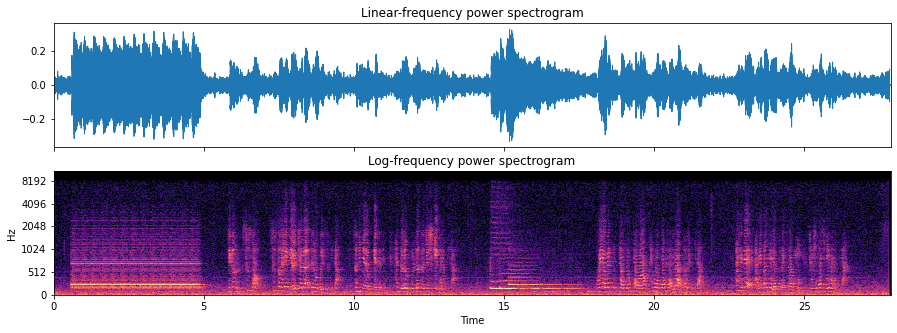

In [5]:
## analyze audio with librosa
x, sr = librosa.load(input_audio_path)
fig, ax = plt.subplots(figsize=(15, 5), nrows=2, ncols=1, sharex=False)

librosa.display.waveplot(x, sr=sr, ax=ax[0], x_axis='time')
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

D = librosa.amplitude_to_db(np.abs(librosa.stft(x, hop_length=160)), ref=np.max)
tmp = librosa.display.specshow(D, y_axis='mel', sr=sr, hop_length=160, x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram')
ax[1].label_outer()
# fig.colorbar(tmp, ax=ax[1], format="%+2.f dB")
plt.plot()

import IPython.display as ipd
ipd.Audio(input_audio_path) # load a local WAV file

# 3. 음성인식 모델 준비

In [6]:
## load model
model = whisper.load_model("base")
print(f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
      f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters.")

100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 132MiB/s]


Model is multilingual and has 71,825,920 parameters.


In [7]:
## load audio and pad/trim it to fit 30 
# input_audio_path = 'audio1.mp3'
audio_raw = whisper.load_audio(input_audio_path)
audio = whisper.pad_or_trim(audio_raw)

print('%s -> %s'%(audio.shape,audio.shape))
print('max value: %s'%audio.max())
print('min value: %s'%audio.min())

(480000,) -> (480000,)
max value: 0.29586792
min value: -0.32943726


torch.Size([80, 3000])
tensor([-0.8257, -0.8257, -0.8257,  ..., -0.8257, -0.8257, -0.8257],
       device='cuda:0')
max value: 0.29586792
min value: -0.32943726


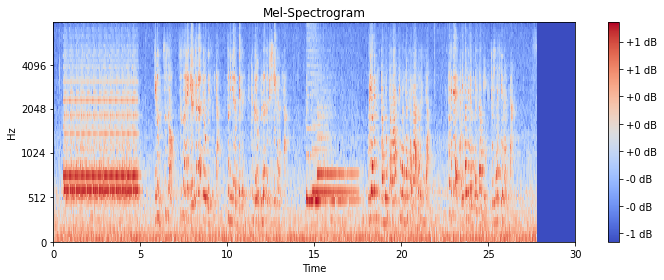

In [8]:
## make log-Mel spectrogram and move to the same device as the model
melspectrogram = whisper.log_mel_spectrogram(audio).to(model.device)

print(melspectrogram.shape)
print(melspectrogram[0])
print('max value: %s'%audio.max())
print('min value: %s'%audio.min())

# plot log_melspectogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(melspectrogram.cpu().numpy(), y_axis='mel', x_axis='time', sr=16000, hop_length=160)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.savefig('Mel-Spectrogram example.png')
plt.show()

## 4. 음성인식!

In [10]:
## run ASR
# decode the audio
options = whisper.DecodingOptions()
result = whisper.decode(model, melspectrogram, options)

# print the recognized text
print(result.text)

지금 수소, 수소행 열차가 들어오고 있습니다. 손님 여러분께서는 한 걸음 물러져 주시기 바랍니다. 우리 옆엔 전동장와 생강장사위가 너를습니다.
